#### Imports

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

#### Reading csv file and checking data types and null value information using info

In [ ]:
data = pd.read_csv("/content/Online Retail.csv", encoding = "ISO-8859-1")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Data dictionary

• InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to
each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to
each distinct product

• Description: Product (item) name. Nominal.

• Quantity: The quantities of each product (item) per transaction. Numeric.

• InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction
was generated

• UnitPrice: Unit price. Numeric, Product price per unit in sterling.

• CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to
each customer

• Country: Country name. Nominal, the name of the country where each customer
resides

## Data Cleaning and EDA

#### Checking for duplicates if any present
- 5268 duplicate rows dropped

In [ ]:
print("Shape before dropping duplicates", data.shape)
data = data.drop_duplicates()
print("Shape after dropping duplicates", data.shape)

Shape before dropping duplicates (541909, 8)
Shape after dropping duplicates (536641, 8)


#### Checking Data Shape and Unique Values in different columns

In [ ]:
print("Data Shape", data.shape)
for col in ["InvoiceNo","StockCode","InvoiceDate","CustomerID", "Country"]:
    print("Unique Values for ", col, " - ", data[col].nunique())

Data Shape (536641, 8)
Unique Values for  InvoiceNo  -  25900
Unique Values for  StockCode  -  4070
Unique Values for  InvoiceDate  -  23260
Unique Values for  CustomerID  -  4372
Unique Values for  Country  -  38


### Checking Nulls in CustomerID

In [ ]:
print(np.sum(data.isnull()), "\n")
print("Percentage of customers missing: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64 

Percentage of customers missing:  25.16 %


#### Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls
- No such cases present as empty dataframe is returned

In [ ]:
null_id_invoices = data[data.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))
### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
data[~data.CustomerID.isnull()][data.InvoiceNo.isin(null_id_invoices)]

Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.

Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer

In [ ]:
data.groupby(['InvoiceNo'])['CustomerID'] \
                             .nunique() \
                             .reset_index(name='nunique') \
                             .sort_values(['nunique'], ascending=False) \
                             .head(5)

,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1


On sorting descending, this data shows that each Invoice relates to maximum of 1 Customer

Creating NewID column and Assigning to InvoiceNo wherever CustomerID is null

In [ ]:
data['NewID'] = data['CustomerID']
data.loc[data['CustomerID'].isnull(), ['NewID']] = data['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
data['NewID'] = data['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
data['NewID'] = pd.to_numeric(data['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = data['CustomerID'].nunique()
null_invoices = data[data.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = data['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


Since both values equal, we know all the different orders that didn't have a customer ID got assigned unique NewID and no duplicates were created

#### Converting object type to datetime for InvoiceDate and checking first and last dates

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
print("Minimum Invoice Date", min(data["InvoiceDate"]))
print("Maximum Invoice Date", max(data["InvoiceDate"]))

Minimum Invoice Date 2010-01-12 08:26:00
Maximum Invoice Date 2011-12-10 17:19:00


#### Adding cancellations column based on definition that InvoiceNo starts with C

In [ ]:
data["cancellations"] = np.where(data["InvoiceNo"].str.startswith('C'), 1,0)
total_data = data["InvoiceNo"].shape[0]
cancelled_data = data[data.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_data, cancelled_data*100/total_data, "\n")

print(data[data.cancellations == 1]["Quantity"].describe())

#### Removing cancellations since they have negative quantities and makes only ~2% of data
data = data[data.cancellations == 0]

Number of cancelled products data 9251 1.7238712658928408 

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


This shows that quantity is negative when any order was cancelled. Removed cancellations data since they only make upto ~2% of data

### Analysis of UnitPrice variable

In [ ]:
print("Minimum UnitPrice", min(data["UnitPrice"]))
print("Maximum UnitPrice", max(data["UnitPrice"]))
data["UnitPrice"].describe()

Minimum UnitPrice -11062.06
Maximum UnitPrice 13541.33


count    527390.000000
mean          3.861939
std          41.963759
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

checking cases where Price <0

In [ ]:
data[data.UnitPrice<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
299983,A563186,B,Adjust bad debt,1,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,563186,0
299984,A563187,B,Adjust bad debt,1,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,563187,0


Removing these two cases

In [ ]:
data = data[data.UnitPrice >= 0]

All rows where Price == 0

In [ ]:
print("% of data with Price = 0: ", round(len(data[data.UnitPrice == 0]) * 100 / len(data),2),"%" )
print("Count of unique Customer ID values ", data[data.UnitPrice == 0].CustomerID.nunique(), "\n")
data[data.UnitPrice == 0][~data.CustomerID.isnull()].head()

% of data with Price = 0:  0.48 %
Count of unique Customer ID values  31 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-05-12 14:02:00,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,165600,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,149110,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-06-01 16:41:00,0.0,13081.0,United Kingdom,130810,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-06-01 16:41:00,0.0,13081.0,United Kingdom,130810,0


In [ ]:
### Dropping Cases with UnitPrice = 0
data_filtered = data[data.UnitPrice >0]
data_filtered["UnitPrice"].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [ ]:
print("Minimum Quantity", min(data_filtered["Quantity"]))
print("Maximum Quantity", max(data_filtered["Quantity"]))
data_filtered["Quantity"].describe()

Minimum Quantity 1
Maximum Quantity 80995


count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

### Customer and total revenue split wrto country

In [ ]:
### Adding Monetary information by calculating total value of transaction by multiplying unit price and quantity of the product
data_filtered["Total_sales"] = data_filtered["UnitPrice"]*data_filtered["Quantity"]

### Creating Country Level grouping to find Unique Customer count and %
country_customer_df = data_filtered.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"]*\
                                          100/country_customer_df["count_CustomerID"].sum(),2)

### Creating Country Level grouping to find total revenue and %
country_df = data_filtered.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"]*100/country_df["Total_sales"].sum(),2)

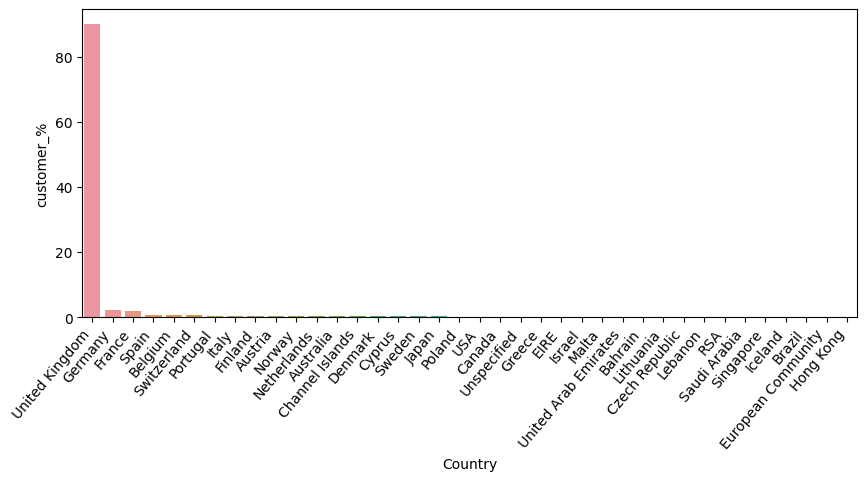

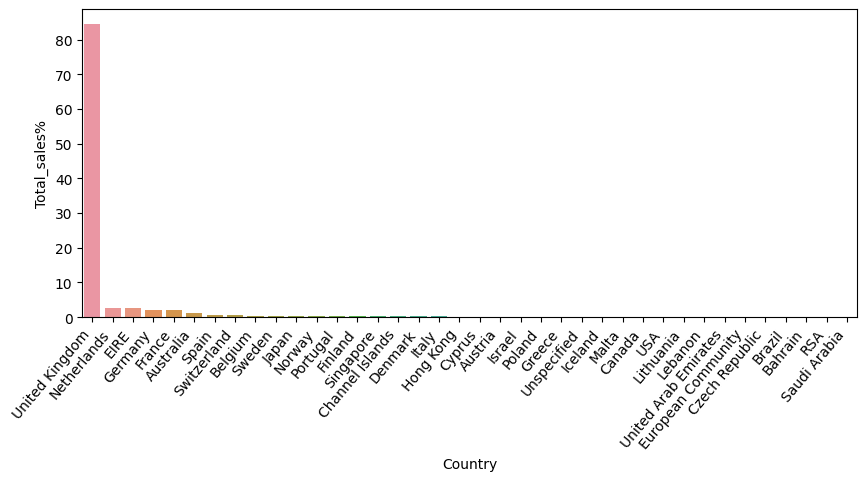

In [ ]:
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_customer_df["Country"], y=country_customer_df['customer_%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_df["Country"], y=country_df['Total_sales%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

The United Kingdom not only has the most sales revenue, but also the most customers. Therefore, for the purpose of this analysis, I will be taking data corresponding to orders from the United Kingdom.

In [ ]:
uk_df = data_filtered[data_filtered.Country == "United Kingdom"]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479985 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      479985 non-null  object        
 1   StockCode      479985 non-null  object        
 2   Description    479985 non-null  object        
 3   Quantity       479985 non-null  int64         
 4   InvoiceDate    479985 non-null  datetime64[ns]
 5   UnitPrice      479985 non-null  float64       
 6   CustomerID     349203 non-null  float64       
 7   Country        479985 non-null  object        
 8   NewID          479985 non-null  int64         
 9   cancellations  479985 non-null  int64         
 10  Total_sales    479985 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 43.9+ MB


Checking Most popular products in United Kingdom

In [ ]:
uk_product = uk_df.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', \
                                                                                                      ascending=False)
uk_product.head(5)

,StockCode,Description,Quantity
2653,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2112,23166,MEDIUM CERAMIC TOP STORAGE JAR,77036
3113,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49430
3601,85099B,JUMBO BAG RED RETROSPOT,44161
3622,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35430


In [ ]:
#Find the unique number of InvoiceNo  per customer for analysis of United Kingdom
groupby_customers = pd.DataFrame(uk_df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.describe()

,InvoiceNo
count,5293.000000
mean,3.404308
std,6.356634
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,209.000000


In [ ]:
#Find the unique number of products per Order
groupby_invoice = pd.DataFrame(uk_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of products per Order']
groupby_invoice.describe()

,Number of products per Order
count,18019.000000
mean,26.351129
std,48.882851
min,1.000000
25%,6.000000
50%,15.000000
75%,29.000000
max,1110.000000


The average number of orders per customer is 1 and average number of products per Order is 15

## RFM Segmentation
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did.

- Recency (R) of a customer: Days since the last purchase.
- Frequency (F) of the bookings/turnover of a customer: Number of purchases, e.g., in 6 months.
- Monetary (M) - The total turnover of a customer: Sum of sales, e.g., in 6 months.

For the analysis, we need to define a ‘analysis date’, which is the day on which we are conducting this analysis which I am taking as the next to last date in data and taking 1 year previous data from the selected date for recency calculation


In [ ]:
analysis_date = uk_df["InvoiceDate"].max() + pd.DateOffset(1)
print("RFM Analysis Date :", analysis_date)

start_date = analysis_date - pd.DateOffset(days = 365)
print("Start Date when taking 1 year data for analysis :", start_date)

RFM Analysis Date : 2011-12-11 17:19:00
Start Date when taking 1 year data for analysis : 2010-12-11 17:19:00


Although, I created column to deal with CustomerID Nulls (NewID), I will now drop rows with Nulls as customerID since these fake customer ID's would skew the analysis, especially the frequency.
Aggregating Remaining dataset to calculate recency, frequency and monetary value columns for every customerID

In [ ]:
### Drop Nulls in CUstomerID
uk_df = uk_df[~uk_df.CustomerID.isnull()]

# Aggregate data on a customer level to get RFM values
data_rfm = uk_df[uk_df.InvoiceDate >= start_date].groupby(['NewID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})
data_rfm.head()

,NewID,Recency,Frequency,Monetary
0,123460,327,1,77183.60
1,127470,24,96,3837.45
2,127480,5,3883,29674.51
3,127490,24,199,4090.88
4,128200,46,59,942.34


In [ ]:
### Getting individual RFM scores by using quantiles for each of the columns
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

### Since a low Recency score means recent transactions and good customer, changine quantile values
### so that low values rank highest ans vice versa
data_rfm['R_score'] = 3 - data_rfm['R_score']

data_rfm['RFM'] = data_rfm.R_score.map(str) \
                            + data_rfm.F_score.map(str) \
                            + data_rfm.M_score.map(str)

### Calculating Final RFM score
data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']
data_rfm.head(10)

,NewID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score
0,123460,327,1,77183.60,0,0,3,003,3
1,127470,24,96,3837.45,2,2,3,223,7
2,127480,5,3883,29674.51,3,3,3,333,9
3,127490,24,199,4090.88,2,3,3,233,8
4,128200,46,59,942.34,2,2,2,222,6
5,128210,97,6,92.72,1,0,0,100,1
6,128220,72,46,948.88,1,2,2,122,5
7,128230,76,5,1759.50,1,0,3,103,4
8,128240,31,25,397.12,2,1,1,211,4
9,128260,61,82,1319.72,2,2,2,222,6


The RFM_Score values will range from 0 (0+0+0) to 9 (3+3+3). Now grouping by the RFM scores to check the mean values of recency, frequency, and monetary corresponding to each score.

In [ ]:
data_rfm.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
RFM_Score,,,
0,247.649518,7.581994,146.476463
1,183.753623,13.895652,220.795188
2,160.032120,20.815846,342.064799
3,104.979638,26.667421,627.106676
4,97.309091,39.257143,1266.646987
5,66.700000,52.407317,1024.498417
6,55.210084,74.120448,1372.810087
7,40.436548,118.763959,1817.034188
8,26.517241,181.846154,3930.945623


As expected, customers with the lowest RFM scores have the highest recency value and the lowest frequency and monetary value, and the vice-versa is true as well. This can be used to create manual segments based on RFM scores like Loyal Customers Group where Frequancy is High, High Spending Group where Monetary is High, Lost Customers Group where Recency is High etc.

Loyal and Good Customers which have High RFM values could be rewarded and heavy discounts are not needed for them. Customers with High Recency (and High Frequency and Monetary values) could be targeted aggresively with discounts so that they are not lost

## Modeling : K - Means Clustering

To properly find out segments on our RFM values, we can use a clustering algorithm like K-means.

                ----------------- Distribution Plots for R,F,M -------------------------------


<Axes: xlabel='Monetary', ylabel='Density'>

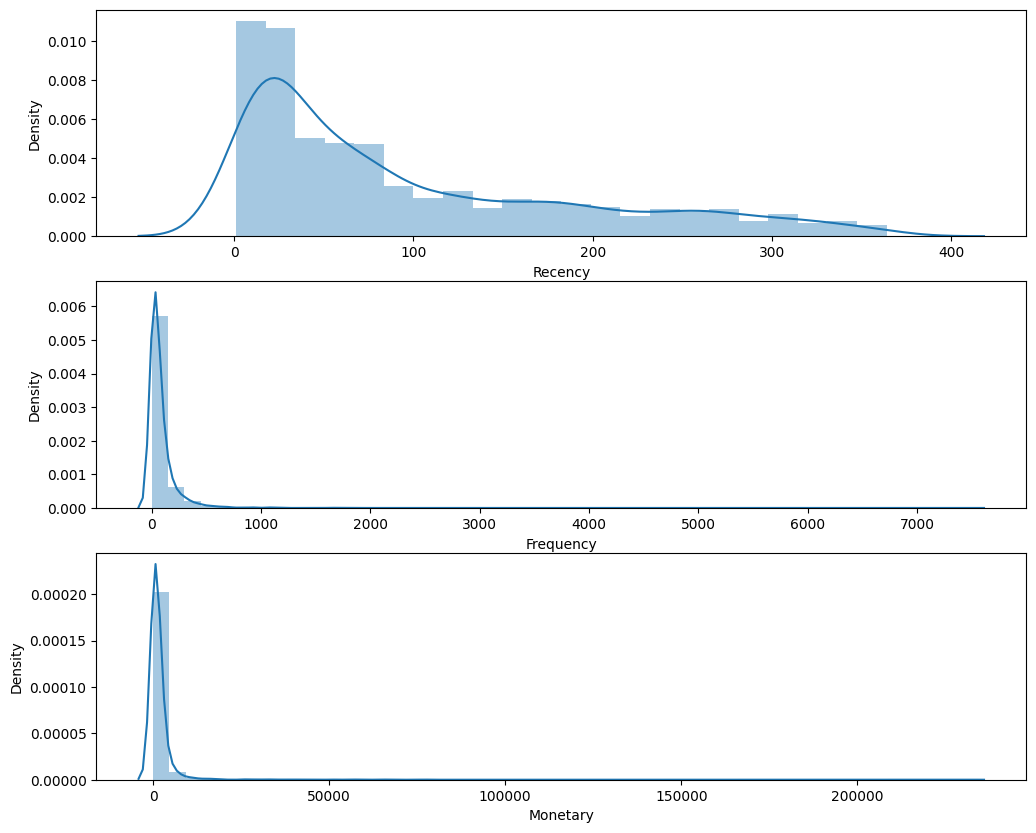

In [ ]:
print("                ----------------- Distribution Plots for R,F,M -------------------------------")

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data_rfm['Recency'])
# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data_rfm['Frequency'])
# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data_rfm['Monetary'])

From the above figure, all the variables do not have a symmetrical distribution. All of them are skewed to the right. Since clustering algorithms require a normal distribution, normalization of the data is required.I am using Log transformation to deal with the skewness of data

                ----------------- Log Transformation Plots for R,F,M -------------------------------


<Axes: xlabel='log_M', ylabel='Density'>

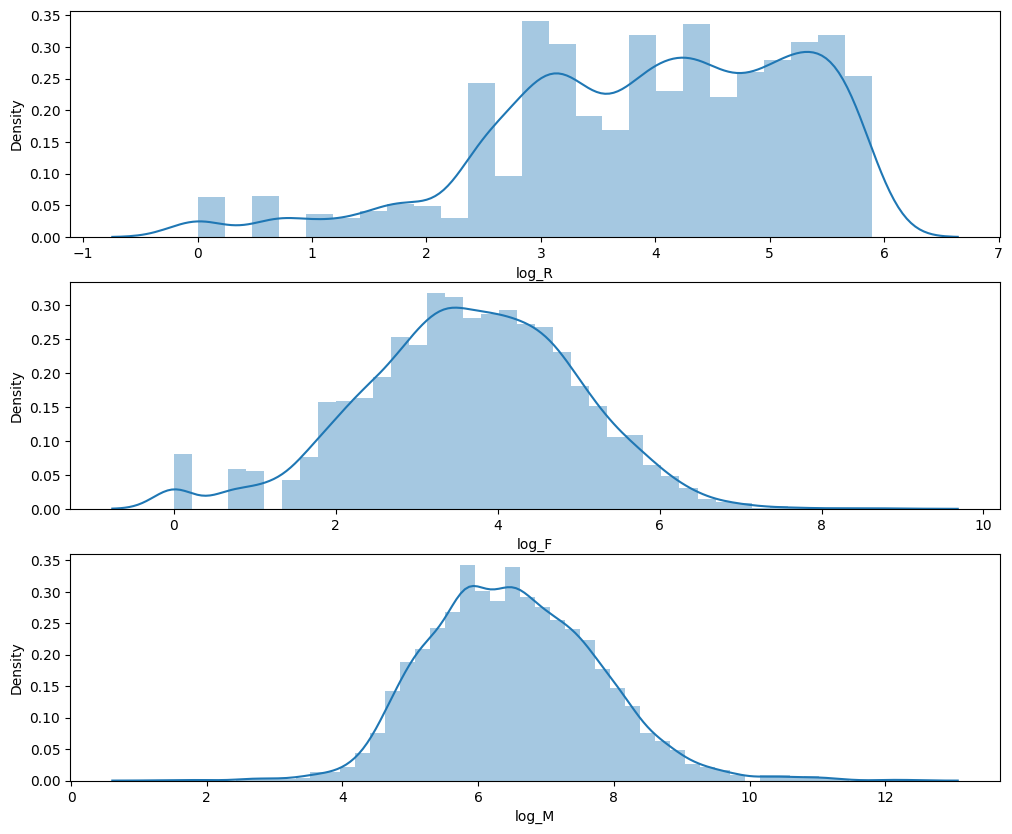

In [ ]:
# Taking Log of columns
data_rfm["log_R"] = np.log(data_rfm.Recency)
data_rfm["log_F"] = np.log(data_rfm.Frequency)
data_rfm["log_M"] = np.log(data_rfm.Monetary)

# Checking the distribution of Recency, Frequency and Monetary variables after log transformation
print("                ----------------- Log Transformation Plots for R,F,M -------------------------------")
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.distplot(data_rfm['log_R'])
plt.subplot(3, 1, 2)
sns.distplot(data_rfm['log_F'])
plt.subplot(3, 1, 3)
sns.distplot(data_rfm['log_M'])



To Find optimal number of clusters, I will use Elbow method where errors are plotted against K (cluster value) to identify optimal number of clusters

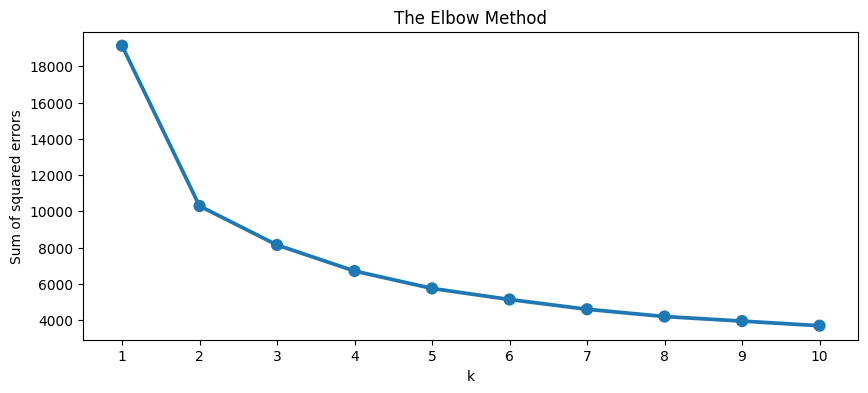

In [ ]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):

    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)

    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)

    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k');
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

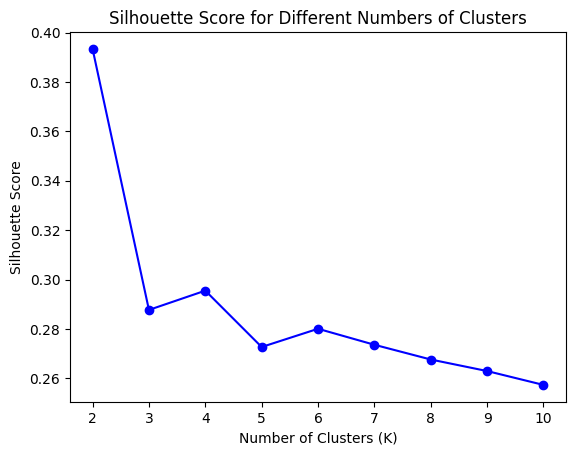

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range of K values
k_values = range(2, 11)  # Try different values of K

# Calculate silhouette scores for each K
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_norm)
    labels = kmeans.labels_
    score = silhouette_score(data_norm, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters (K)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

From the above plot, we can see that the optimal number of clusters can be taken as 3. Now I am building the K Means model using 3 clusters.

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(data_norm)
data_rfm["cluster"] = kmeans.predict(data_norm)

Checking Mean RFM values in different clusters to understand cluster properties

In [ ]:
data_rfm.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,166.714512,13.103886,267.649739
1,91.150437,59.147940,1021.386438
2,20.135903,226.821501,5076.267363


This is the mean value of RFM in different clusters. Clearly there is correlation between Frequency and Monetary -  how their value varies between clusters. This can also be seen in the heat map of these three features shown below. Low value of recency means recent transactions while high frequency means more frequent transactions and high Monetary value means high spending in transactions

<Axes: >

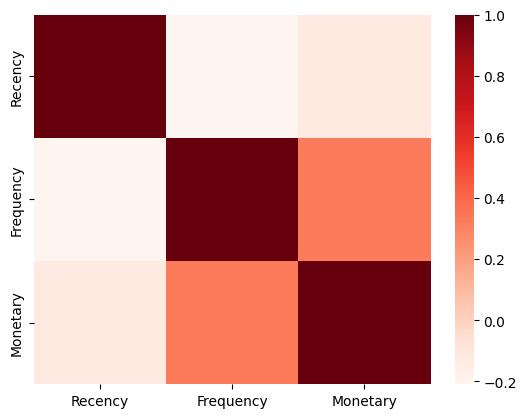

In [ ]:
sns.heatmap(data_rfm[['Recency','Frequency', 'Monetary']].corr(),cmap="Reds")

There is a negative correlation between Recency - Frequency and Recency - Monetary, but there is a positive correlation between Frequency - Monetary which can also be seen in the variation of mean values in clusters

Text(0, 0.5, 'Monetary')

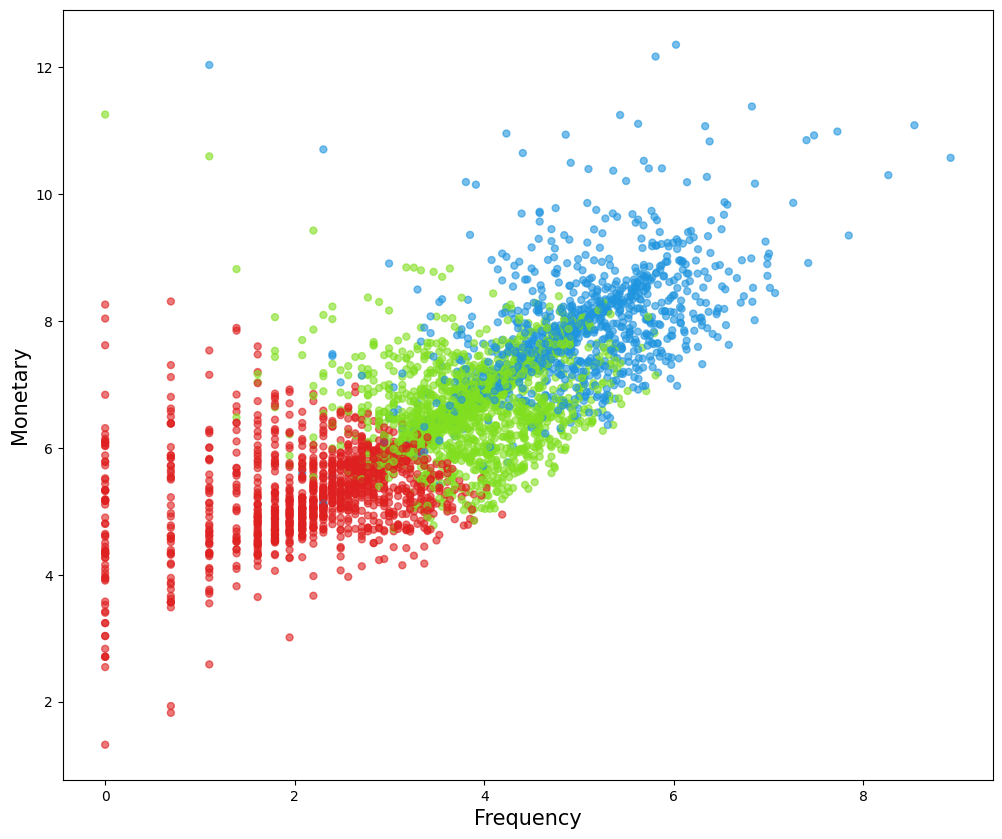

In [ ]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

## add to dataframe
data_rfm['cen_x'] = data_rfm.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
data_rfm['c'] = data_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_F, data_rfm.log_M, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

### This plot clearly indicates that green cluster is high value customer cohort (Cluster 1) and blue cluster is Lost/low value customer cohort (Cluster 2) while red cluster is average value customer cohort (Cluster 0)

- High Value :- Frequent spending customers with high monetary transactions and had transacted recently

- Low Value/ Lost :- Customers with least frequency and monetary spending and made purchase long time ago. These customers might be lost from the customer base.

- Average Value :- Customers who made their transactions some time ago with less frequency and monetary value. These customers could become high risk and we could aggressively market towards them with great deals so we don't lose them forever.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


# Select relevant features for RBM training
selected_features = ['Recency', 'Frequency', 'Monetary'] # Replace with your selected features

# Preprocess the selected features
scaler = MinMaxScaler()
data = scaler.fit_transform(data_rfm[selected_features])

# Define the RBM model architecture
num_visible = len(selected_features)  # Number of visible units
num_hidden = 100  # Number of hidden units

rbm = tf.keras.models.Sequential([
    tf.keras.layers.Dense(num_hidden, activation='sigmoid'),
    tf.keras.layers.Dense(num_visible, activation='sigmoid')
])

# Compile the model
rbm.compile(optimizer='adam', loss='mean_squared_error')

# Train the RBM model
rbm.fit(data, data, epochs=20, batch_size=32)

Epoch 1/20
121/121 [==============================] - 1s 2ms/step - loss: 0.0795
Epoch 2/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 3/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 4/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 5/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 6/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 7/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 8/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 9/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 10/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 11/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 12/20
121/121 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 13/20
121/121 [====

In [ ]:
# Extract features using the trained RBM model
hidden_representation = rbm.layers[0].activation(data)

# Print the extracted features data
print(hidden_representation)

tf.Tensor(
[[0.71055306 0.5        0.58247251]
 [0.51583492 0.50317085 0.50413427]
 [0.50275479 0.62674807 0.53195416]
 ...
 [0.64452102 0.50036716 0.50018797]
 [0.50688662 0.52401355 0.5022019 ]
 [0.5        0.50230305 0.50197732]], shape=(3849, 3), dtype=float64)


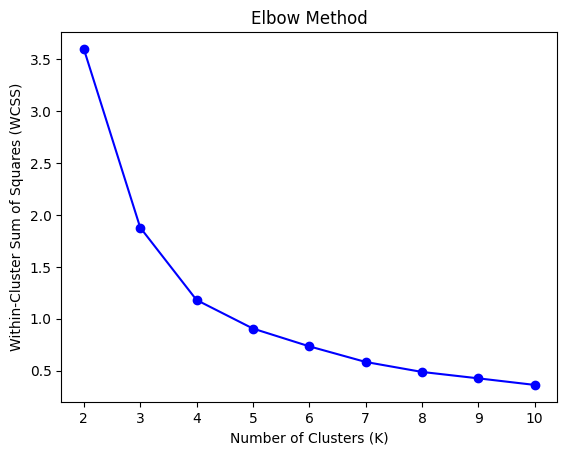

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define a range of K values
k_values = range(2, 11)  # Try different values of K

# Calculate the within-cluster sum of squares (WCSS) for each K
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(hidden_representation)
    wcss.append(kmeans.inertia_)

# Plot the WCSS against the number of clusters (K)
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

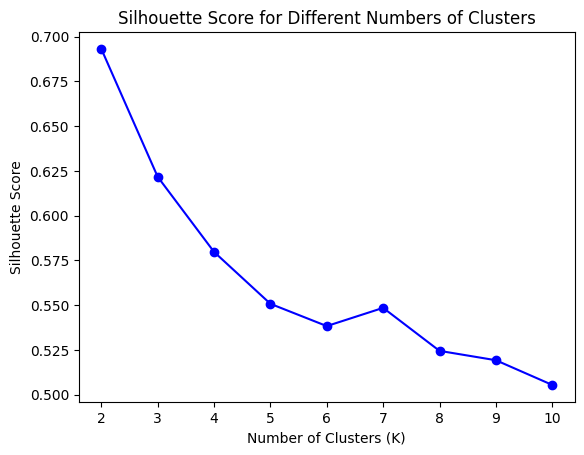

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define a range of K values
k_values = range(2, 11)  # Try different values of K

# Calculate silhouette scores for each K
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(hidden_representation)
    labels = kmeans.labels_
    score = silhouette_score(hidden_representation, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters (K)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

In [ ]:
hidden_array = hidden_representation.numpy()
# Assign column names to the hidden_array
column_names = ['Recency', 'Frequency', 'Monetary']
hidden_df = pd.DataFrame(hidden_array, columns=column_names)

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(hidden_representation)
hidden_df["cluster"] = kmeans.predict(hidden_df)

In [ ]:
print(hidden_df)

       Recency  Frequency  Monetary  cluster
0     0.710553   0.500000  0.582473        1
1     0.515835   0.503171  0.504134        0
2     0.502755   0.626748  0.531954        0
3     0.515835   0.506608  0.504408        0
4     0.530952   0.501936  0.501012        0
...        ...        ...       ...      ...
3844  0.608443   0.500300  0.500191        1
3845  0.502755   0.500200  0.500083        0
3846  0.644521   0.500367  0.500188        1
3847  0.506887   0.524014  0.502202        0
3848  0.500000   0.502303  0.501977        0

[3849 rows x 4 columns]


In [ ]:
hidden_df.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,0.530244,0.503598,0.502469
1,0.651367,0.501019,0.500615


<Axes: >

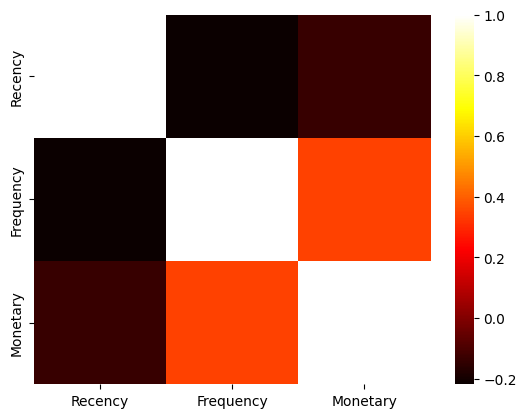

In [ ]:
sns.heatmap(hidden_df[['Recency','Frequency', 'Monetary']].corr(),cmap="hot")

Text(0, 0.5, 'Monetary')

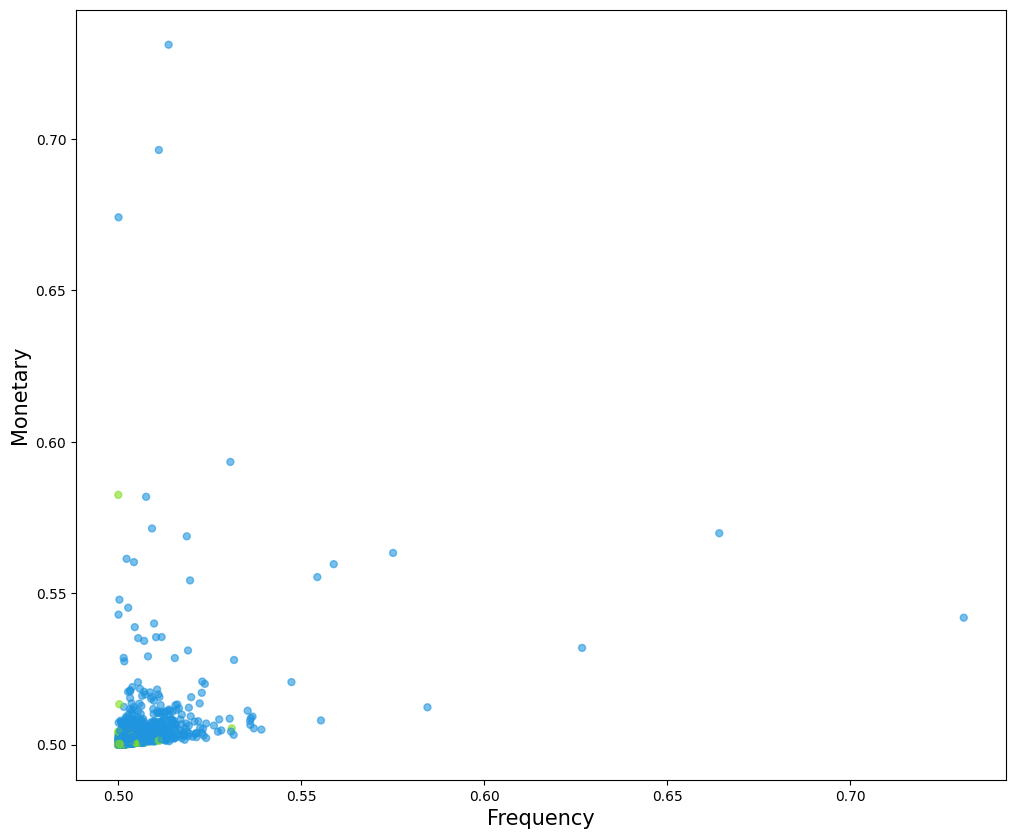

In [ ]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

## add to dataframe
hidden_df['cen_x'] = hidden_df.cluster.map({0:cen_x[0], 1:cen_x[1]})
hidden_df['cen_y'] = hidden_df.cluster.map({0:cen_y[0], 1:cen_y[1]})

# define and map colors
colors = ['#2095DF', '#81DF20']
hidden_df['c'] = hidden_df.cluster.map({0:colors[0], 1:colors[1]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(hidden_df.Frequency, hidden_df.Monetary, c=hidden_df.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)